# Experiment 02: BCI

This experiment uses a Brain Computer Interface dataset. The purpose is to try and predict when the participant is paying attention. The dataset consists of recordings from a number of electrodes placed over the scalp.

In [39]:
import numpy as np
import pandas as pd
import seaborn
from copy import deepcopy
from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib
import json

from libs.loaders import load_bci
from libs.timer import Timer

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## XGBoost vs LightGBM benchmark¶

We will compare both libraries on speed and preformance.

Below we define the modeling pipelines for our two classifiers.

In [2]:
pipeline_steps = [('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [3]:
featurisers = [('continuous', continuous_pipeline)]

In [4]:
xgb_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                subsample=1))])

In [5]:
lgbm_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', LGBMClassifier(num_leaves=2**3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                subsample=1))])

The dataset has been preprepared by extracting 800ms epochs from each channel. The data was then lowpass filtered at 18Hz and downsampled by a factor of 6. This results is a feature vector of


In [6]:
%%time
X, y, X_test, y_test = load_bci()

CPU times: user 2.42 s, sys: 1.04 s, total: 3.46 s
Wall time: 24.1 s


In [7]:
metrics_dict = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'AUC': roc_auc_score,
    'F1': f1_score,
}

def classification_metrics(metrics, y_true, y_pred):
    return {metric_name:metric(y_true, y_pred) for metric_name, metric in metrics.items()}

In [8]:
results_dict = dict()

### XGBoost

In [9]:
with Timer() as t_train:
    xgb_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))

In [10]:
with Timer() as t_test:
    y_pred = xgb_clf_pipeline.predict(np.concatenate(X_test))

In [11]:
results_dict['xgb']={
    'train_time': t_train.interval,
    'test_time': t_test.interval,
    'performance': classification_metrics(metrics_dict, 
                                          np.concatenate(y_test), 
                                          y_pred) 
}

### LightGBM

In [12]:
with Timer() as t_train:
    lgbm_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))

In [13]:
with Timer() as t_test:
    y_pred = lgbm_clf_pipeline.predict(np.concatenate(X_test))

In [14]:
results_dict['lgbm']={
    'train_time': t_train.interval,
    'test_time': t_test.interval,
    'performance': classification_metrics(metrics_dict, 
                                          np.concatenate(y_test), 
                                          y_pred) 
}

In [15]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "AUC": 0.5318846153846153,
            "Accuracy": 0.8812311809969889,
            "F1": 0.12561576354679804,
            "Precision": 0.6071428571428571,
            "Recall": 0.07005494505494506
        },
        "test_time": 0.23858023900538683,
        "train_time": 5.389664636226371
    },
    "xgb": {
        "performance": {
            "AUC": 0.5277435897435897,
            "Accuracy": 0.8812311809969889,
            "F1": 0.11027568922305765,
            "Precision": 0.6285714285714286,
            "Recall": 0.06043956043956044
        },
        "test_time": 0.3745505178812891,
        "train_time": 12.044140707934275
    }
}


## Concept Drift
Concept drift can occur across many domains and can be caused by many factors such as sensor drift, seasonality, regime change, etc. One of the ways to combat this is by retraining. If the cause for the drift is observable then it can be incorporated into the model. In this specific instance the cause for the drift is an increase in the impedance in the electrodes, fatigue as well as a number of other factors. These are not observable in the dataset so we will have to retrain the model at regular intervals and observe the difference in performance. This constant retraining can be costly especially with large datasets. Below we will compare XGBoost and LightGBM in a naive retraining scenario.

In [16]:
def _predict(model, X_test, y_test, auc_list, interval_list):
    with Timer() as t:
        y_pred = model.predict_proba(X_test)
        auc_list.append(roc_auc_score(y_test, y_pred[:, 1]))
    interval_list.append(t.interval)

In [17]:
def run_train_retrain_comparison(model, X, y, X_test, y_test):
    retrain_model = deepcopy(model)
    historical_X = deepcopy(X.tolist())
    historical_y = deepcopy(y.tolist())
    train_auc = list()
    retrain_auc = list()
    test_interval = list()
    retrain_test_interval = list()
    retrain_interval = list()
    
    for X_test_run, y_test_run in  tqdm_notebook(zip(X_test, y_test), total=len(y_test)):
        prev_model = deepcopy(retrain_model)
        
        _predict(model, X_test_run, y_test_run, train_auc, test_interval)
        _predict(retrain_model, X_test_run, y_test_run, retrain_auc, retrain_test_interval)
        
        historical_X.append(X_test_run)
        historical_y.append(y_test_run)

        new_train_X  = np.concatenate(historical_X)
        with Timer() as t:
            retrain_model.fit(new_train_X, np.concatenate(historical_y))
        retrain_interval.append(t.interval)    
        
    return pd.DataFrame({
        'Test interval':test_interval,
        'Retrain Test interval':retrain_test_interval,
        'Retrain interval':retrain_interval,
        'Train AUC':train_auc,
        'Retrain AUC':retrain_auc
    })

In [18]:
df = run_train_retrain_comparison(xgb_clf_pipeline, X, y, X_test, y_test)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [19]:
retrain_results_dict = dict()

In [20]:
retrain_results_dict['xgb'] = df

In [21]:
df = run_train_retrain_comparison(lgbm_clf_pipeline, X, y, X_test, y_test)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [22]:
retrain_results_dict['lgbm'] = df

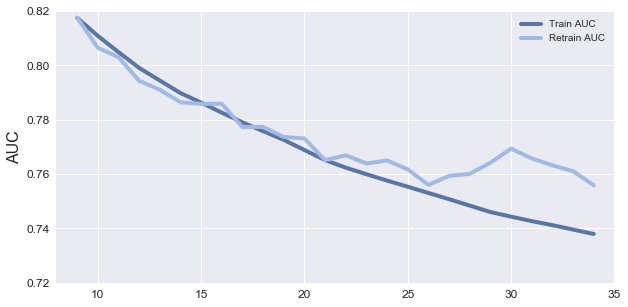

In [63]:
# XGB Retrain Results
ax=retrain_results_dict['xgb'][['Train AUC', 'Retrain AUC']].rolling(window=10).mean().plot(xlim=[8, 35], 
                                                                                            ylim=[.72, .82],
                                                                                            fontsize=12,
                                                                                            linewidth=4,
                                                                                            figsize=(10,5),
                                                                                            color=['#5975a4', '#a1bae3'])
ax.set_ylabel('AUC', fontsize=16);
ax.get_figure().savefig('xgb_retrain_results.svg', bbox_inches='tight') 

Overall we can see that retraining does seem to help a bit. Ofcourse the retraining done here is naive with no consideration that later samples may also contain more noise. 

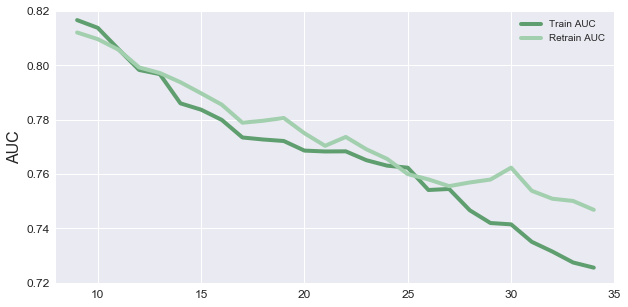

In [64]:
# LGBM Retrain Results
ax=retrain_results_dict['lgbm'][['Train AUC', 'Retrain AUC']].rolling(window=10).mean().plot(xlim=[8, 35],
                                                                                             ylim=[.72, .82],
                                                                                            fontsize=12,
                                                                                            linewidth=4,
                                                                                            figsize=(10,5),
                                                                                            color=['#5f9e6f', '#a2cfae'])
ax.set_ylabel('AUC', fontsize=16);
ax.get_figure().savefig('lgbm_retrain_results.svg', bbox_inches='tight') 

Retrainig does also seem to improve the results for the LightGBM model.

In [31]:
xgb_series = retrain_results_dict['xgb'][['Retrain Test interval', 'Retrain interval', 'Test interval']].sum()
lgbm_series = retrain_results_dict['lgbm'][['Retrain Test interval', 'Retrain interval', 'Test interval']].sum()

In [41]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
matplotlib.rcParams['figure.figsize'] = (6., 10.)

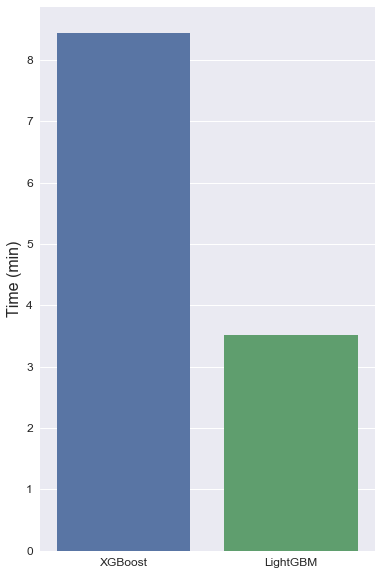

In [65]:
# XGB vs LGBM Retrain Time
t_res = pd.DataFrame([['XGBoost', xgb_series['Retrain interval']/60],
              ['LightGBM', lgbm_series['Retrain interval']/60]], columns=['Model', 'Time(m)'])
ax = seaborn.barplot(x="Model", y="Time(m)", data=t_res)
ax.set_ylabel('Time (min)', fontsize=16);
ax.set_xlabel('');
ax.get_figure().savefig('xgb_vs_lgbm_retrain_time.svg', bbox_inches='tight') 

LightGBM seems to be almost twice as fast as XGBoost and offer similar performance. In general, leaf-wise algorithms are more efficient and converge faster than depth-wise. However, it can easily over-fit when the data is small or the number of leaves is too high.